In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xml.etree import ElementTree as ET

plt.style.use('ggplot')

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## The Data Story

My wife and I have recently started to consider what life might look like after New York City. She's been here 15 years and I've been here 10 and we both agree that it's time for a change. One of the cities at the top of our list is Denver, Colorado. One of the appealing points to the city is that, unlike New York, we could afford to buy a house. This got me thinking--how can I use data science to learn more about the real estate situation in Denver? 

Fortunately for me, Denver has a great open data catalog: https://www.denvergov.org/opendata/. One of the datasets available is [Real Property Sales and Transfers](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-sales-and-transfers) which contains all records of property ownership transfers from 2008 to the present. What luck! A second dataset titled [Real Property Residential Characteristics](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-residential-characteristics) will be used to add additional information such as number of bedrooms and square footage to my analysis.

## Importing the dataset

The Real Property Sales and Transfers dataset is in relatively good shape and doesn't need too much work to clean.

In [3]:
df_sales = pd.read_csv('datasets/real_property_sales_and_transfers.csv')

C:\Users\Trent\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sales_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', sheetname='Sales_Transfers', header=3, parse_cols=[1,2,3,5])
sales_dict

,Field Name,Example,Column Type,Description
0,PIN,163752899,Text,Assessor's Property Identification Number
1,SCHEDNUM,0231416005000,Text,Assessor's Schedule Number
2,RECEPTION_NUM,2011148564,Text,Clerk & Recorder's Reception Number
3,RECEPTION_DATE,20101004,Text,Clerk & Recorder's Reception Date
4,INSTRUMENT,WD,Text,Type of Instrument
5,SALE_YEAR,2010,Text,Sale Year
6,SALE_MONTHDAY,0928,Text,Sale Month/Day
7,SALE_PRICE,199677,Text,Sale Price
8,GRANTOR,"SMITH, JOHN & JANE",Text,Person(s) relinquishing ownership
9,GRANTEE,"BROWN, JAMES",Text,Person(s) recieving ownership


In [5]:
df_sales.head()

,SCHEDNUM,RECEPTION_NUM,INSTRUMENT,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,GRANTOR,GRANTEE,CLASS,MKT_CLUS,D_CLASS,D_CLASS_CN,NBHD_1,NBHD_1_CN,PIN
0,3100025000,2015007009,WD,2015,120,20150121,9350000.000,PEP LENOCH DENVER V LLC &,MENIFEE MART INC,C,nan,22M,MIXED USE-HOTEL/RESD,4,GATEWAY N,163547560
1,3100028000,2014036460,WD,2014,331,20140402,7900000.000,SMITA MERCHANT INC,S&RN MANAGEMENT INC,C,nan,28T,MISC IMPS-TIE BACK,4,GATEWAY N,163556381
2,3100028000,2011125634,WD,2011,1102,20111104,5400000.000,CAMPBELL HOLDINGS,SMITA MERCHANT INC,C,nan,28T,MISC IMPS-TIE BACK,4,GATEWAY N,163556381
3,3100036000,2009028420,PS,2009,304,20090306,nan,CORPOREX HIGH POINT LLC,CORPOREX HIGH POINT LLC,A,nan,022,VCNT LAND BA-2 ZONE,4,GATEWAY N,163596315
4,3100037000,2009028420,PS,2009,304,20090306,nan,CORPOREX HIGH POINT LLC,CORPOREX HIGH POINT LLC,C,nan,223,HOTEL - RESIDENCE/SUITE,4,GATEWAY N,163596323


## Filtering the dataset to only show single family home sales

Since I'm only interested in the data about single family homes, I'll filter out everything else.

In [6]:
single_family_home = 'SINGLE FAMILY'

df_sales = df_sales[df_sales.D_CLASS_CN == single_family_home]

A quick look at the number of home sales and transfers each year shows that 2008 was the biggest year in the dataset in terms of volume--which makes perfect sense. Since then, the volume each year has hovered 15,000. 

_Note: The dip in 2016 sales and transfers can be attributed to incomplete data since the year isn't complete._

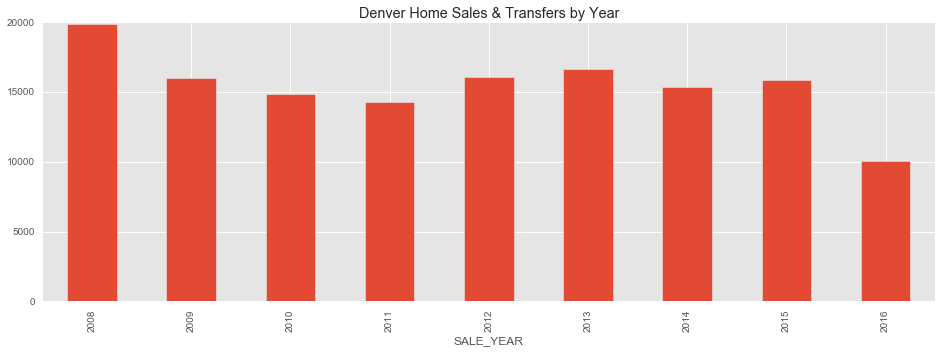

In [8]:
df_sales.groupby('SALE_YEAR').size().plot('bar', 
                                          figsize=(16, 5),
                                          title= "Denver Home Sales & Transfers by Year");

Obviously, we want to find the right neighborhood, but we're not sure what that even means yet. As a starting point, I want to know what neighborhoods had the most sales and transfers. Plotting the neighborhoods with the highest mean sale price will tell me which neighborhoods I can't afford.

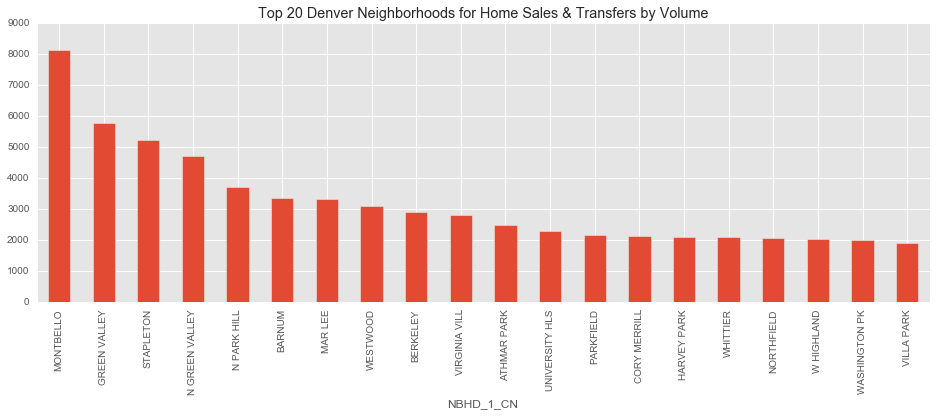

In [9]:
df_sales.groupby('NBHD_1_CN').size().sort_values(ascending=False).head(20).plot('bar', 
                                          figsize=(16, 5),
                                          title= "Top 20 Denver Neighborhoods for Home Sales & Transfers by Volume");

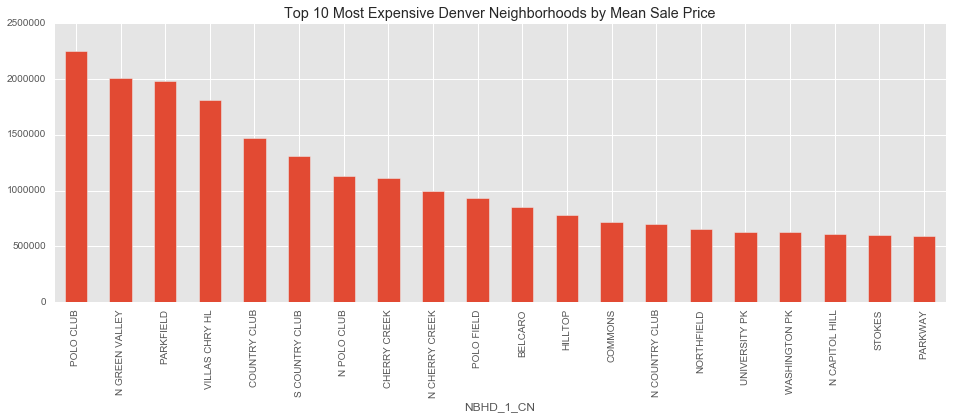

In [10]:
df_sales.groupby('NBHD_1_CN')['SALE_PRICE'].mean().sort_values(ascending=False).head(20).plot('bar', 
                                          figsize=(16, 5),
                                          title= "Top 10 Most Expensive Denver Neighborhoods by Mean Sale Price");

## Adding datetime and setting it as the index

It would also be interesting to dig a little deeper into the trends that might exist in sales and transfers over time. In order to do this, I'll need to convert the SALE_YEAR and SALE_MONTHDAY columns into a new column with datetime formatting. 

In [11]:
days = []
months = []
years = df_sales.SALE_YEAR.astype(str)
datetimes = []

for row in df_sales.SALE_MONTHDAY:
    row = str(row)
    if len(row) < 4:
        row = '0' + row
    days.append(row[:-2])
    months.append(row[2:])
    
df_sales['date'] = years + '-' + months + '-' + days

df_sales['date'] = pd.to_datetime(df_sales['date'], format='%Y-%d-%m')

df_sales.index = df_sales.date

df_sales['year'] = df_sales.index.year
df_sales['month'] = df_sales.index.month
df_sales['day'] = df_sales.index.day

In [12]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sales_2013 = df_sales['2013']['SALE_PRICE'].resample('M', how='count')
sales_2014 = df_sales['2014']['SALE_PRICE'].resample('M', how='count')
sales_2015 = df_sales['2015']['SALE_PRICE'].resample('M', how='count')
sales_2016 = df_sales['2016']['SALE_PRICE'].resample('M', how='count')

monthly_df = pd.DataFrame({'Month': months,
                           '2013' : sales_2013.values,
                           '2014' : sales_2014.values,
                           '2015' : sales_2015.values})

C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  from ipykernel import kernelapp as app
C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  app.launch_new_instance()
C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()


In [13]:
monthly_df.index = monthly_df.Month

Looking at monthly sales for both 2014 and 2015 clearly shows that there are seasonal trends in home sales and transfers.

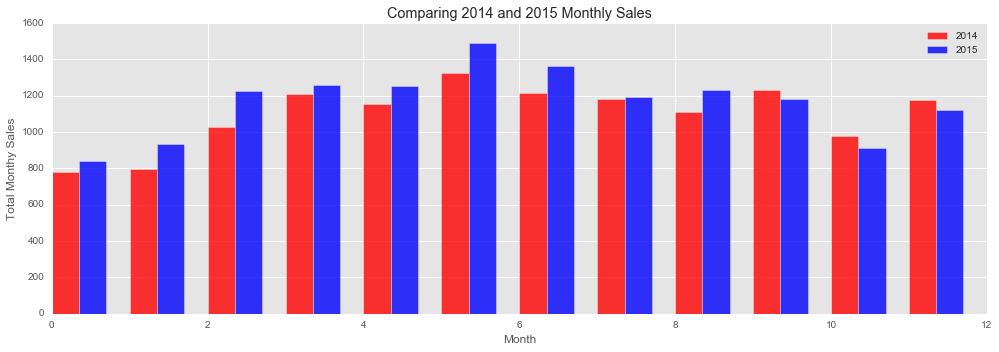

In [14]:
# data to plot
n_groups = 12

# create plot
fig, ax = plt.subplots(figsize=(14,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, monthly_df['2014'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='2014')
 
rects2 = plt.bar(index + bar_width, monthly_df['2015'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='2015')
 
plt.xlabel('Month')
plt.ylabel('Total Monthy Sales')
plt.title('Comparing 2014 and 2015 Monthly Sales')
plt.legend()
 
plt.tight_layout()
plt.show()

## Importing Property Characteristics dataset

Now, I'm going to add in the Real Property Residential Characteristics dataset. For an initial look at the data, let's see how square footage and sale price are related.

In [15]:
df_characteristics = pd.read_csv('datasets/real_property_residential_characteristics.csv', usecols=['PIN',
                                                                                          'LAND_SQFT',
                                                                                          'AREA_ABG',
                                                                                          'BSMT_AREA', 
                                                                                          'FBSMT_SQFT',
                                                                                          'BED_RMS',
                                                                                          'FULL_B',
                                                                                          'HLF_B'], error_bad_lines=False)

Skipping line 63332: expected 46 fields, saw 47
Skipping line 63335: expected 46 fields, saw 47
Skipping line 63338: expected 46 fields, saw 47

Skipping line 68348: expected 46 fields, saw 48
Skipping line 69469: expected 46 fields, saw 47
Skipping line 69470: expected 46 fields, saw 47
Skipping line 69471: expected 46 fields, saw 47
Skipping line 69472: expected 46 fields, saw 47



In [33]:
df_full_info = df_sales.merge(df_characteristics, how='left', on='PIN')

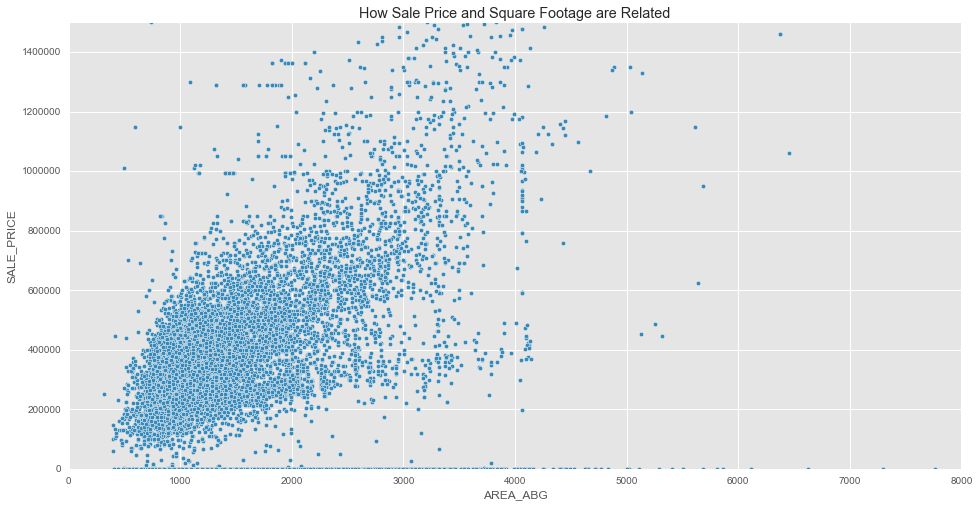

In [34]:
df_full_info[df_full_info.year == 2015].plot(x='AREA_ABG', 
                                             y='SALE_PRICE', 
                                             kind='scatter', 
                                             figsize=(16, 8), 
                                             xlim=(0, 8000),
                                             ylim=(0, 1500000),
                                             title="How Sale Price and Square Footage are Related");

This visualization shows what I would expect--higher square footage correlates with a higher sale price.

That's the end of my initial look into the data. There's still some cleaning to do. For example, the last visualization shows several observations that have a sale price of $0. That will require further exploration, and I'm looking forward to digging deeper into the data for my capstone project.